# Employing a Neural Network to Predict Taxi Fares in New York City

In this programme we are going to employ a neural network to make predictions for taxi fares in New York City. The NYC taxi fares dataset (available from Kaggle) contains millions of samples, but we will only make use of approximately 500,000 of these. The dataset features detail the fare paid for the journey, the pickup and drop off locations, and the time/date of the pickup. 

We begin by reading in the first half a million lines of the CSV file into a Pandas dataframe. Use of the parse_dates parameter means the associated values will be datetime objects.

In [28]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# read the data into a dataframe
df = pd.read_csv('NYC_taxi_fares.csv', parse_dates = ['pickup_datetime'])

Let's view the first six rows of the dataframe and check the data types.

In [29]:
df.head(6)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502684 entries, 0 to 502683
Data columns (total 8 columns):
key                  502684 non-null object
fare_amount          502684 non-null float64
pickup_datetime      502684 non-null datetime64[ns, UTC]
pickup_longitude     502684 non-null float64
pickup_latitude      502684 non-null float64
dropoff_longitude    502679 non-null float64
dropoff_latitude     502679 non-null float64
passenger_count      502684 non-null int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 30.7+ MB


We can see that the 'pickup_datetime' column consists of datetime objects. Also the drop off columns appear to have five missing values each. We can confirm this is the case by explicitly checking for missing values.

In [31]:
# check for missing values
print(df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64


We will drop the rows with missing values.

In [32]:
df = df.dropna()

Viewing the columns it is clear that we should not have any zero values in the dataset so let's check for these

In [33]:
# get the dataframe column names
column_names = df.columns
print('Number of zero values per column')
# for each column in the dataframe, print the number of zero values it contains
for column in column_names:
    print('{}: {}'.format(column, sum(df[column] == 0)))

Number of zero values per column
key: 0
fare_amount: 14
pickup_datetime: 0
pickup_longitude: 9476
pickup_latitude: 9452
dropoff_longitude: 9500
dropoff_latitude: 9470
passenger_count: 1806


Again we will drop all rows with zero values as we can afford to with the size of the dataset. We do this by converting all zeros to NaN values and then using the dropna method to remove the rows that contain any of these values.

In [34]:
# replace zeros with NaN values
df = df.replace(0, np.nan)
# drop rows containing NaN values
df = df.dropna(how = 'any')

We get no new information from the 'key' column so we will drop this also.

In [35]:
df = df.drop('key', axis = 1)

Now we are going to define the longitude and latitude ranges for New York City so that we can exclude any samples that fall outside of this range.

In [36]:
# longitude range for New York City
min_long = -74.05
max_long = -73.75

# latitude range for New York City
min_lat = 40.63
max_lat = 40.85

# introduce a copy of the dataframe that we can work with without altering the original dataframe
df2 = df.copy()
# keep samples in df2 for which the pickup and dropoff longitudes fall within the allowed
# longitude range for New York City
for long in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long] > min_long) & (df2[long] < max_long)]

# do the same for latitudes
for lat in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat] > min_lat) & (df2[lat] < max_lat)]

We can plot the pickup locations and overlay New York City landmarks onto the plot.

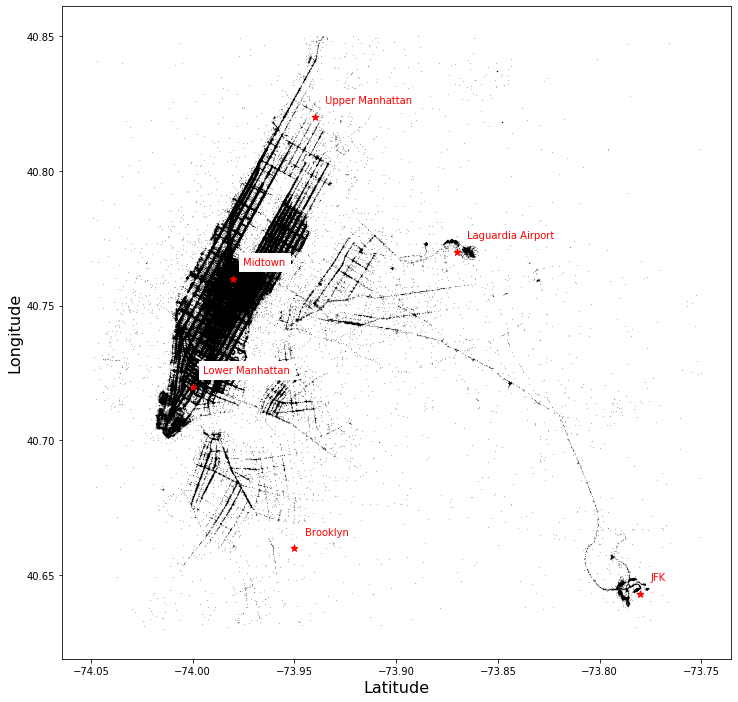

In [37]:
# define a dictionary of landmarks in New York City and their locations that we can add to the plot
landmarks = {'JFK': (-73.78, 40.643), 'Laguardia Airport': (-73.87, 40.77),
            'Midtown': (-73.98, 40.76), 'Lower Manhattan': (-74, 40.72),
            'Upper Manhattan': (-73.94, 40.82), 'Brooklyn': (-73.95, 40.66)}

# plot pickup locations 
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
ax.scatter(list(df2['pickup_longitude']), list(df2['pickup_latitude']), color = 'k', s = 0.01)
ax.set_xlabel('Latitude', size = 16)
ax.set_ylabel('Longitude', size = 16)
# add landmarks to the map
for i in landmarks:
    # plot markers on map using the landmarks dictionary
    ax.scatter(landmarks[i][0], landmarks[i][1], marker = '*', color = 'r', s = 50)
    # add landmark names from the dictionary
    ax.annotate(i, (landmarks[i][0] + 0.005, landmarks[i][1] + 0.005), color = 'r', backgroundcolor = 'w')
plt.show()

We can do the same thing for the drop off locations.

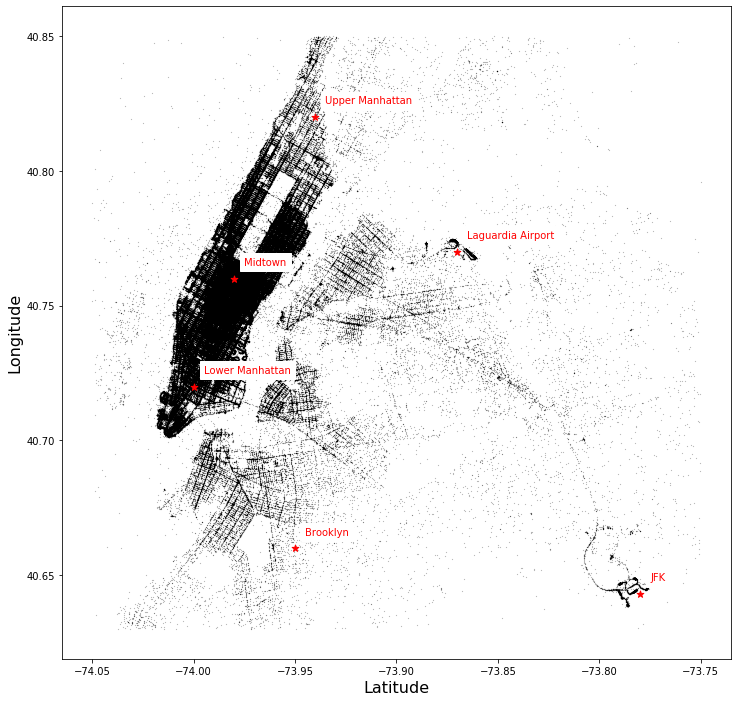

In [38]:
# plot drop off locations 
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)
ax.scatter(list(df2['dropoff_longitude']), list(df2['dropoff_latitude']), color = 'k', s = 0.01)
ax.set_xlabel('Latitude', size = 16)
ax.set_ylabel('Longitude', size = 16)
# add landmarks to the map
for i in landmarks:
    # plot markers on map using the landmarks dictionary
    ax.scatter(landmarks[i][0], landmarks[i][1], marker = '*', color = 'r', s = 50)
    # add landmark names from the dictionary
    ax.annotate(i, (landmarks[i][0] + 0.005, landmarks[i][1] + 0.005), color = 'r', backgroundcolor = 'w')
plt.show()

By comparing the two plots we can see that there are more drop offs in the residential areas of the city than pickups.

Next we will explore how the number of rides varies by day and hour. Let's start by creating new columns for the dataframe from the 'pickup_datetime' column (which we can then drop). We can use the dt function to separate the 'pickup_datetime' feature into the year, month, day and hour. 

In [39]:
# create new columns from the 'pickup_datetime' column
df2['year'] = df2['pickup_datetime'].dt.year
df2['month'] = df2['pickup_datetime'].dt.month
df2['day'] = df2['pickup_datetime'].dt.day
df2['day_of_week'] = df2['pickup_datetime'].dt.dayofweek
df2['hour'] = df2['pickup_datetime'].dt.hour
# drop original column
df2 = df2.drop('pickup_datetime', axis = 1)

We can plot a histogram to see how the number of rides varies throughout the week.

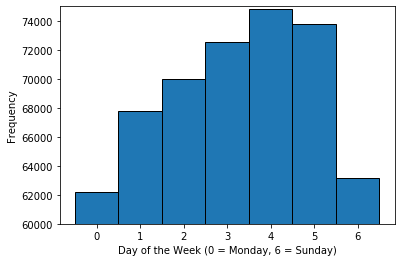

In [40]:
# generate histogram plot
df2['day_of_week'].plot.hist(bins = np.arange(8)-0.5, ec = 'black', ylim = (6e+4, 7.5e+4))
plt.xlabel('Day of the Week (0 = Monday, 6 = Sunday)')
plt.show()

The number of taxi rides per day increases daily from Monday to Friday, drops slightly on Saturday and drastically falls on Sunday.

Now we produce a histogram to visualise how the number of rides varies throughout the day.

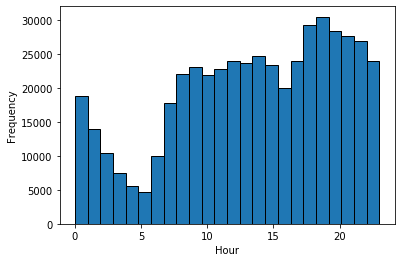

In [41]:
# generate histogram plot
df2['hour'].plot.hist(bins = 24, ec = 'black')
plt.xlabel('Hour')
plt.show()

The number of rides is lowest during the early hours of the morning and peaks in the evening.

Let's get some summary statistics for the dataset.

In [42]:
df2.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,484342.000000,484342.000000,484342.000000,484342.000000,484342.000000,484342.000000,484342.000000,484342.000000,484342.000000,484342.000000,484342.000000
mean,11.036056,-73.975666,40.750897,-73.974586,40.751147,1.689657,2011.739475,6.270499,15.678657,3.040626,13.523465
std,8.963012,0.033575,0.026228,0.032047,0.028475,1.305905,1.865943,3.439755,8.680743,1.948340,6.492624
min,-18.100000,-74.049288,40.630097,-74.049897,40.630056,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992262,40.736638,-73.991549,40.735910,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.982095,40.753380,-73.980680,40.753850,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.968478,40.767396,-73.965803,40.768236,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,-73.750322,40.849922,-73.750061,40.849988,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


We can see that we have negative fare amounts in the dataset, which obviously is not possible. Let's view the fare distribution.

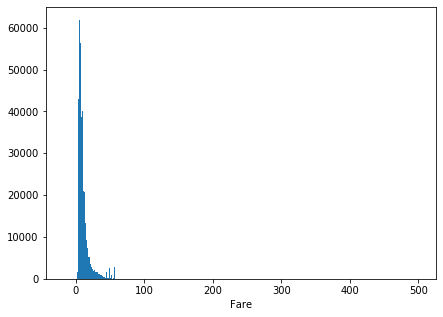

In [43]:
# generate histogram plot
df2['fare_amount'].hist(bins=500, grid = False, figsize = (7, 5))
plt.xlabel('Fare')
plt.show()

Viewing the distribution we decide that all fares above \\$100 or less than or equal to \\$0 are outliers and will be removed from the dataset.

In [44]:
# keep samples for which the fare is greater than $0 and less than or equal to $100
df2 = df2[(df2['fare_amount'] <= 100) & (df2['fare_amount'] > 0)]

We have seen that the dataset contains information on drop off and pickup locations but no information on the distance of the journey. Therefore, we will create a new feature which calculates the distance between the pickup and drop off locations.

In [45]:
# define a function for calculating the euclidean distance
def distance(pu_long, pu_lat, do_long, do_lat):
    return np.sqrt((do_long - pu_long)**2 + (do_lat - pu_lat)**2)

# produce new column in df2 using the function
df2['distance'] = distance(df2['pickup_longitude'], df2['pickup_latitude'], df2['dropoff_longitude'], 
                          df2['dropoff_latitude'])

Let's plot distance against fare amount.

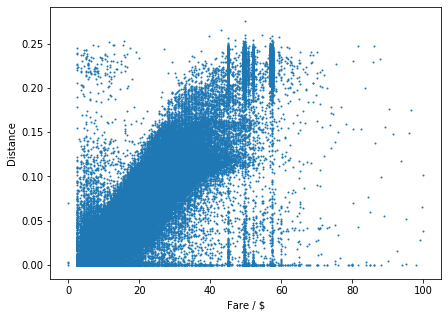

In [46]:
# generate scatter plot
fig = plt.figure(figsize = (7, 5))
ax = fig.add_subplot(111)
ax.scatter(df2['fare_amount'], df2['distance'], s = 1)
ax.set_xlabel('Fare / $')
ax.set_ylabel('Distance')
plt.show()

As we would expect, the fare is generally correlated with the distance travelled in the taxi journey. However, there are three vertical lines on the plot between \\$40 and \\$60. It turns out that these lines correspond to flat rates (plus tolls) charged near airports, regardless of distance travelled.

Therefore, we should create another new feature that details the distances between the pickup and drop off locations and the three airports in New York City. This will enable the neural network to learn that pickups and drop offs near airports entail a flat fare between \\$40 and \\$60.

In [47]:
# define a dictionary of New York City airports and their locations
airports = {'JFK': (-73.78, 40.643), 'Laguardia Airport': (-73.87, 40.77), 'Newark Airport': (-74.18, 40.69)}

# for each airport in the dictionary...
for i in airports:
    # calculate the distance between the pickup location and the airport and add to newly created column
    df2['pickup_dist_' + i] = distance(df2['pickup_longitude'], df2['pickup_latitude'], airports[i][0], airports[i][1])
    # calculate the distance between the drop off location and the airport and add to newly created column
    df2['dropoff_dist_' + i] = distance(df2['dropoff_longitude'], df2['dropoff_latitude'], airports[i][0], airports[i][1])

Before we construct the neural network we should perform feature scaling to ensure that all features have an indentical scale range and no one feature dominates over all the others.

In [48]:
# scale the features, excluding the target 'fare_amount'
scaler = StandardScaler()
X = df2.drop('fare_amount', axis = 1)
X_scaled = scaler.fit_transform(X)

# assign target variable to y
y = df2['fare_amount']

# separate the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state = 11)

We are going to construct a deep neural network with four hidden layers; the first layer containing 128 nodes and each of the following containing half the number of nodes of the previous. The nodes in the hidden layers will all utilise the ReLU activation function. The output layer will consist of a single node which will output the predicted fare amount. Because this variable is continuous, we are dealing with a regression problem and the output node will not use an activation function as we are not seeking to tranform the input into a value between zero and one. In regression problems the Root Mean Square Error (RMSE) is usually a good choice for a loss function.

In [49]:
# create sequential model
model = Sequential()
# add hidden layers to model. The input dimension of the first hidden layer is the number of features in the dataset
model.add(Dense(128, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
# add output layer with no activation function
model.add(Dense(1))

# print mode summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               2304      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 13,185
Trainable params: 13,185
Non-trainable params: 0
_________________________________________________________________


The output above shows the composition of the model with respect to its layers, nodes and trainable parameters (weights and biases). Now we can compile the model ready for training, specifying the 'adam' optimiser which employs a form of stochastic gradient descent. The loss function will be utilised as the metric to measure model performance. 

In [50]:
# compile the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
# train the model with 10 epochs (we would use more epochs ideally)
model.fit(X_train, y_train, epochs = 10, verbose = 0)

Let's evaluate the performance of the model.

In [51]:
# make predictions on training data
train_pred = model.predict(X_train)
# calculate rmse for predictions
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

# make predictions on test data
test_pred = model.predict(X_test)
# calculate rmse for predictions
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print('Train RMSE: {:.2f}'.format(train_rmse))
print('Test RMSE: {:.2f}'.format(test_rmse))

Train RMSE: 3.48
Test RMSE: 3.48


As we would expect, performance on the test set isn't quite as good as on the training set. Finally, we will create a function which will make fare predictions on test samples.

In [52]:
def predict_sample(df2, X_test, y_test, model):
    
    # get a random number between zero and the total number of test samples to act as an index
    index = random.randint(0, X_test.shape[0])
    # get the actual fare corresponding to the index from the test set
    y_test = np.array(y_test)
    actual_fare = y_test[index]
    
    # get the scaled days from the test set (the ninth column)
    scaled_days = X_test[:, 8]
    # get the unique entries in this array in order to make a dictionary
    unique_vals = np.unique(X_test[:, 8])
    # create a dicitonary that will map the scaled values to the day strings they represent
    days_dict = {unique_vals[0]: 'Monday', unique_vals[1]: 'Tuesday', unique_vals[2]: 'Wednesday', unique_vals[3]: 'Thursday', 
                 unique_vals[4]: 'Friday', unique_vals[5]: 'Saturday', unique_vals[6]: 'Sunday'}
    # get the scaled day corresponding to the index and map to the day string
    day_of_week = days_dict[scaled_days[index]]
    
    # get the scaled hours from the test set (the tenth column)
    scaled_hours = X_test[:, 9]
    # get the unique entries in this array in order to make a dictionary
    unique_vals2 = np.unique(X_test[:, 9])
    # create a dicitonary that will map the scaled values to the hours they represent
    hours_dict = {unique_vals2[0]: 0, unique_vals2[1]: 1, unique_vals2[2]: 2, unique_vals2[3]: 3, unique_vals2[4]: 4, 
                  unique_vals2[5]: 5, unique_vals2[6]: 6, unique_vals2[7]: 7, unique_vals2[8]: 8, unique_vals2[9]: 9,
                 unique_vals2[10]: 10, unique_vals2[11]: 11, unique_vals2[12]: 12, unique_vals2[13]: 13, unique_vals2[14]: 14,
                 unique_vals2[15]: 15, unique_vals2[16]: 16, unique_vals2[17]: 17, unique_vals2[18]: 18, unique_vals2[19]: 19,
                 unique_vals2[20]: 20, unique_vals2[21]: 21, unique_vals2[22]: 22, unique_vals2[23]: 23}
    # get the scaled hour corresponding to the index and map to the original unscaled hour
    hour = hours_dict[scaled_hours[index]]
    
    # use the model to predict the fare
    predicted_fare = model.predict(X_test[index].reshape(1, 17))[0][0]
    # calculate RMSE
    rmse = np.sqrt(np.square(predicted_fare - actual_fare))
    
    # print the results
    print('Trip details: {}, {}:00hrs'.format(day_of_week, hour))
    print('Actual fare: ${:.2f}'.format(actual_fare))
    print('Predicted fare: ${:.2f}'.format(predicted_fare))
    print('RMSE: ${:.2f}'.format(rmse))
    

Let's see some examples of this function's output

In [62]:
for i in range(10):
    predict_sample(df2, X_test, y_test, model)
    print('\n')

Trip details: Sunday, 0:00hrs
Actual fare: $10.50
Predicted fare: $10.10
RMSE: $0.40


Trip details: Tuesday, 12:00hrs
Actual fare: $5.30
Predicted fare: $5.05
RMSE: $0.25


Trip details: Saturday, 13:00hrs
Actual fare: $5.70
Predicted fare: $6.43
RMSE: $0.73


Trip details: Sunday, 2:00hrs
Actual fare: $6.10
Predicted fare: $6.86
RMSE: $0.76


Trip details: Sunday, 15:00hrs
Actual fare: $8.10
Predicted fare: $8.25
RMSE: $0.15


Trip details: Wednesday, 11:00hrs
Actual fare: $33.87
Predicted fare: $30.02
RMSE: $3.85


Trip details: Wednesday, 1:00hrs
Actual fare: $8.00
Predicted fare: $9.43
RMSE: $1.43


Trip details: Monday, 14:00hrs
Actual fare: $57.33
Predicted fare: $51.93
RMSE: $5.40


Trip details: Saturday, 11:00hrs
Actual fare: $6.50
Predicted fare: $6.08
RMSE: $0.42


Trip details: Wednesday, 12:00hrs
Actual fare: $8.50
Predicted fare: $9.99
RMSE: $1.49




We can see that the model makes some very good predictions, especially for shorter journeys. 